# Homework 2: Learning to Rank <a class="anchor" id="toptop"></a>

**Submission instructions**:
- Only the code `TODO: Implement this!` denotes that these sections are graded. Please do not delete the comment #YOUR CODE HERE.
- Vectoriize your code instead of using for-loop when implementing Neural Nets.
- The notebook you submit has to have the student ids, separated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 
- This will be parsed by a regexp, so please double check your filename.
- Only one member of each group has to submit the file to canvas.
- Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  
- Please do not delete/add new cells. Removing cells can lead to grade deduction. Also do not change the number of parameters in the pre-defined functions.
- Note, that you are not allowed to use Google Colab.

**Learning Goals**:
- Part 1: Offline LTR
  - Learn how to implement pointwise, pairwise and listwise algorithms for learning to rank 
- Part 2: Online LTR
  - Implement learning to rank algorithms from historical clicks and online evaluation of ranking algorithms.
- Learn their weaknesses & strengths and when each method is suitable. 



**Files to submit along with the completed notebook**:
- `pointwise_regression.json`
- `pointwise_classification.json`
- `pairwise.json`
- `listwise.json`
- `biased_model.json'
- `unbiased_model.json'


---
**Recommended Reading**:
- Part 1:
  - Chris Burges, Tal Shaked, Erin Renshaw, Ari Lazier, Matt Deeds, Nicole Hamilton, and Greg Hullender. Learning to rank using gradient descent. InProceedings of the 22nd international conference on Machine learning, pages 89–96, 2005.
  - Christopher J Burges, Robert Ragno, and Quoc V Le. Learning to rank with nonsmooth cost functions. In Advances inneural information processing systems, pages 193–200, 2007
  - (Sections 1, 2 and 4) Christopher JC Burges. From ranknet to lambdarank to lambdamart: An overview. Learning, 11(23-581):81, 2010
  

Additional Resources: 
- This assignment requires knowledge of [PyTorch](https://pytorch.org/). If you are unfamiliar with PyTorch, you can go over [these series of tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

In the previous assignment, you experimented with retrieval with different ranking functions and in addition, different document representations. 

This assignment deals directly with learning to rank (LTR). In offline LTR (Part 1), You will learn how to implement methods from the three approaches associated with learning to rank: pointwise, pairwise and listwise. 

In Part 2, you will learn about online LTR. Instead of using manually judged datasets, in online LTR, we learn from user interactions. You will learn how to simulate clicks using click models, how to learn unbiasedly from historical clicks and how to evaluate different rankers in an online environment using multileaving methods. 

**Note:**
  - The dataset used in this assignment is +100Mb in size. You may need around 2Gb of RAM for running the whole notebook.


# Table of Contents  <a class="anchor" id="top"></a>

[Back to top](#toptop)


Table of contents:


 - [Chapter 1: Offline LTR](#o_LTR) (345 points)
     - [Section 1: Dataset and Utility](#dataU) 
     - [Section 2: Pointwtise LTR](#pointwiseLTR) (55 points)
     - [Section 3: Pairwise LTR](#pairwiseLTR) (60 points)
     - [Section 4: Pairwise Speed-up RankNet](#SpairwiseLTR) (70 points)
     - [Section 5: Listwise LTR](#listwiseLTR) (80 points)
     - [Section 6: Evaluation](#evaluation1) (70 points)
 - [Chapter 2: Online LTR](#onLTR) (180 points)
     - [Section 1: Clicks Simulation](#clicks) (15 points)
     - [Section 2: Counterfactual](#cLTR) (90 points)
     - [Section 3: Online Evaluation](#on_eval) (75 points)

In [1]:
import os
import json
import itertools
from argparse import Namespace
from collections import OrderedDict
from functools import partial


import torch
import numpy as np
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd

import dataset
import evaluate


# Chapter 1: Offline LTR <a class="anchor" id="o_LTR"></a>

A typical setup of learning to rank involves a feature vector constructed using a query-document pair, and a set of relevance judgements. You are given a set of triples (`query`, `document`, `relevance grade`); where relevance grade is an *ordinal* variable  with  5  grades,  for example: {`perfect`,`excellent`,`good`,`fair`,`bad`),  typically  labeled  by human annotators.  

In this assignment, you are already given the feature vector for a given document and query pair. To access these vectors, see the following code cells (note: the dataset will be automatically downloaded & the first time the next cell runs, it will take a while!)

## Section 1: Data and Utility <a class="anchor" id="dataU"></a>

[Back to TOC](#top)

First let's get familiar with the dataset and some utility methods for our implementations.

### Section 1.1 Dataset stats

| Split Name | \# queries | \# docs | \# features |
| :- | :--: | :--: | :--: |
| train | 2735 | 85227 | 501 |
| validation | 403 | 12794 | 501 |
| test | 949 | 29881 | 501 |


In [2]:
dataset.download_dataset()
data = dataset.get_dataset()
# there is only 1 fold for this dataset 
data = data.get_data_folds()[0]
# read in the data
data.read_data()

In [3]:
print(f"Number of features: {data.num_features}")
# print some statistics
for split in ["train", "validation", "test"]:
    print(f"Split: {split}")
    split = getattr(data, split)
    print(f"\tNumber of queries {split.num_queries()}")
    print(f"\tNumber of docs {split.num_docs()}")

Number of features: 501
Split: train
	Number of queries 2735
	Number of docs 85227
Split: validation
	Number of queries 403
	Number of docs 12794
Split: test
	Number of queries 949
	Number of docs 29881


### Section 1.2 Utility classes/methods

The following cells contain code that will be useful for the assigment. 

In [4]:
# these is a useful class to create torch DataLoaders, and can be used during training
class LTRData(Dataset):
    def __init__(self, data, split):
        split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert split is not None, "Invalid split!"
        features, labels = split.feature_matrix, split.label_vector
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, i):
        return self.features[i], self.labels[i]

In [5]:
## example 
train_dl = DataLoader(LTRData(data, "train"), batch_size=32, shuffle=True)
# this is how you would use it to quickly iterate over the train/val/test sets 
# - (of course, without the break statement!)
for (x, y) in train_dl:
    print(x.size(), y.size())
    break

torch.Size([32, 501]) torch.Size([32])


`evaluate_model` evaluates a model, on a given split.

In [6]:
# this function evaluates a model, on a given split
def evaluate_model(pred_fn, split, batch_size=256, print_results=False, q_level=False):
    dl = DataLoader(LTRData(data, split), batch_size=batch_size)
    all_scores = []
    all_labels = []
    for (x, y) in tqdm(dl, desc=f'Eval ({split})', leave=False):
        all_labels.append(y.squeeze().numpy())
        
        with torch.no_grad():
            output = pred_fn(x)
            all_scores.append(output.squeeze().numpy())
            
    split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
    }.get(split)   
    results = evaluate.evaluate2(np.asarray(all_scores), np.asarray(all_labels), print_results=print_results, q_level=q_level)

    return results


In [7]:
## example 
# function that scores a given feature vector e.g a network
net = nn.Linear(501, 1)
# the evaluate method accepts a function. more specifically, a callable (such as pytorch modules) 
def notwork(x):
    return net(x)
# evaluate the function
_ = evaluate_model(notwork, "validation", print_results=True)

"metric": "mean" ("standard deviation")
dcg: 86.3697 (21.49473)
dcg@03: 6.1985 (5.06002)
dcg@05: 8.1926 (5.66094)
dcg@10: 12.0000 (7.20056)
dcg@20: 18.3366 (8.97258)
ndcg: 0.6942 (0.06573)
ndcg@03: 0.2263 (0.19503)
ndcg@05: 0.2255 (0.16515)
ndcg@10: 0.2386 (0.14390)
ndcg@20: 0.2744 (0.12104)
precision@01: 0.2200 (0.41425)
precision@03: 0.2000 (0.26667)
precision@05: 0.1760 (0.20254)
precision@10: 0.1540 (0.16151)
precision@20: 0.1480 (0.11574)
recall@01: 0.0109 (0.02212)
recall@03: 0.0276 (0.04092)
recall@05: 0.0384 (0.05103)
recall@10: 0.0678 (0.07856)
recall@20: 0.1291 (0.09710)
relevant rank: 107.7290 (75.73203)
relevant rank per query: 2544.5600 (1369.46172)


C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The next cell is used to generate reproducible results:

In [8]:
# use to get reproducible results
def seed(random_seed):
    import random
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    

## Section 2: Pointwise LTR (55 points) <a class="anchor" id="pointwiseLTR"></a>

[Back to TOC](#top)

Let $x \in \mathbb{R}^d$ be an input feature vector, containing features for a query-document pair. Let $f: \mathbb{R}^d \rightarrow \mathbb{R} $ be a function that maps this feature vector to a number $f(x)$ - either a relevance score (regression) or label (classification). The data $\{x \}$ are treated as feature vectors and the relevance judgements are treated as the target which we want to predict. 

In this section, you will implement a simple Pointwise model using either a regression or classification loss, and use the train set to train this model to predict (or classify) the relevance score. 


### Section 2.1: Neural Model (5 points)

In the following cell, you will implement a simple pointwise LTR model: 
- Use a neural network to learn a Pointwise model using both a regression and a classification loss, using the relevance grades as the label. Use the following parameters: 
  - Layers: $501 (input) \rightarrow 256 \rightarrow o$ where $o$ is either 5 for classification or 1 for regression, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLU`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)
  - Note: Do not use a `nn.Softmax` function here - it will be taken care of later!
  - This network will also be used by other methods i.e Pairwise 


In [9]:
# TODO: Implement this! (5 points)
class NeuralModule(nn.Module):
    def __init__(self, output_dim):
        """
        Initializes the Pointwise neural network. 
        Input: output_dim: The dimension of the output layer. In this assignment, 
                it is either 1 (regression) or 5 (classification)
        """
        
        # YOUR CODE HERE
        super().__init__()
        self.model = nn.Sequential(
                nn.Linear(501,256),
                nn.ReLU(),
                nn.Linear(256,output_dim)
        )
        
    def forward(self, x):
        """
        Takes in an input feature vector (of size 501) and produces the (regression/classification) output 
        Input: x: a [N, 501] tensor
        Output: a [N, output_dim] tensor
        """
        # YOUR CODE HERE
        return self.model(x)

In [10]:
point_nn_clf = NeuralModule(5)
point_nn_reg = NeuralModule(1)

In [11]:
# YOUR CODE HERE
print(point_nn_clf)

# global performance dictionary and time import
perf_dict = {}
import time

NeuralModule(
  (model): Sequential(
    (0): Linear(in_features=501, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [12]:
# test the forward function
n = 10
inp = torch.rand(n, data.num_features)
out = point_nn_clf(inp)
### BEGIN HIDDEN TEST
n = 20
inp = torch.rand(n, data.num_features)
out = point_nn_clf(inp)
assert out.size(0) == n
assert out.size(1) == 5
### END HIDDEN TEST

In [13]:
# test the forward function
n = 10
inp = torch.rand(n, data.num_features)
out = point_nn_reg(inp)
### BEGIN HIDDEN TEST
n = 20
inp = torch.rand(n, data.num_features)
out = point_nn_reg(inp)
assert out.size(0) == n
assert out.size(1) == 1
### END HIDDEN TEST

### Section 2.2: Loss Functions (5 points)
Pointwise LTR algorithms use pointwise loss functions.
Usually, the popular loss functions for pointwise LTR are:
 - Cross entropy loss for classification (3 points)
 - Regression loss (2 points)

**Implementation (3 points):**
Implement cross entropy loss and and then cross entropy prediction.

In [14]:
# TODO: Implement this! (2 points)
def clf_loss(output, target):
    """
    Cross entropy loss - returns a single number. 
    output: (float) tensor, shape - [N, 5] 
    target: (float/long) tensor, shape - [N]. 
    
    Hint: This function should also handle cases when target is either long/float types 
    """
    assert output.size(0) == target.size(0)
    assert output.size(1) == 5
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target.long())
    return loss

In [15]:
## Test clf_loss
g = torch.manual_seed(42)
tests = [torch.rand(5, 5, generator=g) for _ in range(5)]
target = torch.LongTensor([1, 2, 3, 4, 0])

results = [1.5910069942474365, 
           1.600582480430603, 
           1.6723783016204834, 
           1.8065979480743408, 
           1.6385562419891357]

l1 = [clf_loss(output, target).item() for output in tests]
print(f'your results: {l1}')
print(f'expected results: {results}')


your results: [1.5910069942474365, 1.600582480430603, 1.6723783016204834, 1.8065980672836304, 1.6385562419891357]
expected results: [1.5910069942474365, 1.600582480430603, 1.6723783016204834, 1.8065979480743408, 1.6385562419891357]


In [16]:
# TODO: Implement this! (1 points)
def clf_pred(inp, net):
    """
    The output of the classifier network produces a [Nx5] output corresponding to 
    the relevance labels (each row does *not* add to 1!)
    This function should predict the most probable relevance from the relevance labels
    
    inp: The input [N, num_features]
    net: the neural network, takes in [N, num_features] and outputs [N, 5]
    
    return: a [N, 1] (long) tensor, the relevance labels
    """
    # YOUR CODE HERE
    output = net(inp)
    return torch.argmax(output,1)

In [17]:
g = torch.manual_seed(42)
def clf_(inp):
    return torch.rand(inp.size(0), 5, generator=g)

inp = torch.rand(10, 5, generator=g)
r = np.array([3, 3, 2, 1, 2, 4, 4, 1, 3, 1])
p = clf_pred(inp, clf_).numpy()
print(f'your results:{p}')
print(f'expected:{r}')


your results:[3 3 2 1 2 4 4 1 3 1]
expected:[3 3 2 1 2 4 4 1 3 1]


In [18]:
# NOTE:
# to construct a predictor for a particular network, see this example
# (this will be required in the next cell)
clf_pred_fn = partial(clf_pred, net=point_nn_clf)
# the 'net' argument doesn't need to be provided anymore!
clf_pred_fn(torch.rand(5, data.num_features)).numpy()


array([3, 2, 3, 3, 2], dtype=int64)

**Implementation (2 points):**
Implement regression loss.

In [19]:
# TODO: Implement this! (2 points)
def reg_loss(output, target):
    """
    Regression loss - returns a single number. 
    Make sure to use the TODO loss!
    output: (float) tensor, shape - [N, 1] 
    target: (float) tensor, shape - [N]. 
    """
    assert target.dim() == 1
    assert output.size(0) == target.size(0)
    assert output.size(1) == 1
    
    # YOUR CODE HERE
    loss = nn.MSELoss()
    output = output.squeeze()
    return loss(output,target)

In [20]:
## Test reg_loss
g = torch.manual_seed(42)
output = [torch.randint(low=0, high=5, size=(5, 1), generator=g).float() for _ in range(5)]
target = torch.randint(low=0, high=5, size=(5,), generator=g).float()

l = [reg_loss(o, target).item() for o in output]
r = [4.800000190734863, 
     3.0, 
     7.599999904632568, 
     5.400000095367432, 
     0.6000000238418579]
print(f'your results:{l}')
print(f'expected:{r}')

your results:[4.800000190734863, 3.0, 7.599999904632568, 5.400000095367432, 0.6000000238418579]
expected:[4.800000190734863, 3.0, 7.599999904632568, 5.400000095367432, 0.6000000238418579]


**Implementation (45 points):**
Now implement a wrapper for training a pointwise LTR, that takes the model and the loss function as input and trains the model.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 5 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Appropriate loss function & prediction function: 5 points
 - Both classification / regression models handled appropriately: 5 points
 - Performance as expected: 15 points

In [21]:
# TODO: Implement this! (45 points)
def train_pointwise(net, loss, params):
    """
    This function should train a Pointwise network, 
    trained based on the loss (either "clf" / "reg"). 
    
    The network is trained using the Adam optimizer
        
    
    Note: Do not change the function definition! 
    
    
    Hints:
    1. Use the LTRData class defined above
    2. You will have to construct a partial function if loss="clf" 
       before using it in evaluate_model() (see cells after the defn of clf_pred)
    
    net: the neural network to be trained
    
    loss: one of "clf" or "reg"
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models.
    
    """
    
    assert loss in {"clf", "reg"}
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    if loss == "clf":
        loss_func = clf_loss
        pred_func = partial(clf_pred, net=net)
    else:
        loss_func = reg_loss
        pred_func = net
    optimizer = Adam(net.parameters(), params.lr)
    train_dl = DataLoader(LTRData(data, "train"), batch_size=params.batch_size, shuffle=True)
    time_list = []
    loss_fn = loss
    for epoch in range(params.epochs):
        running_loss = 0.0
        start_time = time.perf_counter()
        for phase in {"train","eval"}:
            if phase == "train":
                net.train()
                for i, (x, y) in enumerate(train_dl):
                    # Set gradients to zero
                    optimizer.zero_grad()
                    output = net(x)

                    # Compute loss between output and y
                    loss = loss_func(output, y)

                    # Compute gradients
                    loss.backward()

                    # Update weights
                    optimizer.step()
                    # print statistics
                end_time = time.perf_counter()
                time_list.append(end_time-start_time)

            else:
                net.eval()
                train_eval = evaluate_model(pred_func, "train", print_results=False)
                val_eval = evaluate_model(pred_func, "validation", print_results=False)

                aggr_train = {}
                aggr_val = {}
                for metric in params.metrics:
                    aggr_train[metric] = train_eval[metric]
                    aggr_val[metric] = val_eval[metric]

                val_metrics_epoch.append(aggr_train)
                train_metrics_epoch.append(aggr_val)
                
    perf_dict['pointwise_' + loss_fn +'_time'] = time_list

    
    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [22]:
# Change this to test your code!
pointwise_test_params = Namespace(epochs=8, 
                    lr=1e-3,
                    batch_size=256,
                   metrics={"ndcg"})
# uncomment to test your code
## train a regression model
met_reg = train_pointwise(point_nn_reg, "reg", pointwise_test_params)
## train a classification model
met_clf = train_pointwise(point_nn_clf, "clf", pointwise_test_params)

#necessary for section 6 Summary
list_reg_ndcg = []
list_clf_ndcg = []
for i in met_reg['metrics_val']:
    list_reg_ndcg.append(i['ndcg'][0])
    perf_dict['pointwise_reg_ndcg'] = list_reg_ndcg
for i in met_clf['metrics_val']:
    list_clf_ndcg.append(i['ndcg'][0])
    perf_dict['pointwise_clf_ndcg'] = list_clf_ndcg

The next cell is used to generate reproducible results which should be submitted with the assignment:

In [23]:

    
def create_results(net, train_fn, prediction_fn, results_file, *train_params):
    
    print("Training Model")
    metrics = train_fn(net, *train_params)
    net.eval()
    test_metrics, test_qq = evaluate_model(prediction_fn, "test", print_results=True, q_level=True)
    
    
    test_q = {}
    for m in {"ndcg", "precision@05", "recall@05"}:
        test_q[m] = test_qq[m]
    
    with open(results_file, "w") as writer:
        json.dump({
            "metrics": metrics,
            "test_metrics": test_metrics,
            "test_query_level_metrics": test_q,
        }, writer, indent=2)


Now use the above functions to generate your `json` files for submission:

In [24]:
seed(42)
params_regr = Namespace(epochs=11, 
                    lr=1e-3,
                    batch_size=256,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_regression_model = NeuralModule(1)
create_results(pointwise_regression_model, 
               train_pointwise, 
               pointwise_regression_model,
               "./pointwise_regression.json", 
               "reg", params_regr)
# persist models
torch.save(pointwise_regression_model.state_dict(), "./pointwise_regr_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 113.0821 (24.91926)
dcg@03: 21.9233 (8.24672)
dcg@05: 27.6213 (10.18126)
dcg@10: 36.2178 (12.76866)
dcg@20: 46.9553 (14.79701)
ndcg: 0.8728 (0.05280)
ndcg@03: 0.7494 (0.22963)
ndcg@05: 0.7150 (0.19646)
ndcg@10: 0.6872 (0.16288)
ndcg@20: 0.6817 (0.13838)
precision@01: 0.8376 (0.36881)
precision@03: 0.7578 (0.30076)
precision@05: 0.6855 (0.28202)
precision@10: 0.5513 (0.23593)
precision@20: 0.4406 (0.19871)
recall@01: 0.0383 (0.02725)
recall@03: 0.1017 (0.05637)
recall@05: 0.1521 (0.08837)
recall@10: 0.2342 (0.11289)
recall@20: 0.3614 (0.14512)
relevant rank: 63.0332 (61.93446)
relevant rank per query: 1622.1624 (979.54369)


In [25]:
seed(42)
params_clf = Namespace(epochs=13, 
                    lr=1e-3,
                    batch_size=256,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_classification_model = NeuralModule(5)
create_results(pointwise_classification_model,
               train_pointwise,
               partial(clf_pred, net=pointwise_classification_model),
               "./pointwise_classification.json", "clf", params_clf)

torch.save(pointwise_classification_model.state_dict(), "./pointwise_clf_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 108.6116 (25.17168)
dcg@03: 19.5295 (8.57500)
dcg@05: 24.4419 (10.40278)
dcg@10: 32.4805 (12.94910)
dcg@20: 40.7263 (14.69996)
ndcg: 0.8366 (0.06137)
ndcg@03: 0.6649 (0.25002)
ndcg@05: 0.6299 (0.21335)
ndcg@10: 0.6135 (0.17796)
ndcg@20: 0.5882 (0.14838)
precision@01: 0.7436 (0.43665)
precision@03: 0.6752 (0.30650)
precision@05: 0.6034 (0.27172)
precision@10: 0.5000 (0.24073)
precision@20: 0.3551 (0.17991)
recall@01: 0.0334 (0.02796)
recall@03: 0.0902 (0.05554)
recall@05: 0.1314 (0.07825)
recall@10: 0.2074 (0.11004)
recall@20: 0.2836 (0.12403)
relevant rank: 76.3215 (68.50700)
relevant rank per query: 1964.1368 (1027.90876)


YOUR ANSWER HERE

In [26]:
assert os.path.exists("./pointwise_regression.json")
assert os.path.exists("./pointwise_classification.json")

## Section 3: Pairwise LTR (60 points) <a class="anchor" id="pairwiseLTR"></a>

[Back to TOC](#top)

In this section,  you will learn and implement RankNet, a  pairwise learning to rank algorithm.

For a given query, consider two documents $D_i$ and $D_j$ with two different ground truth relevance  labels,  with  feature  vectors $x_i$ and $x_j$ respectively.   The  RankNet  model,  just  like  the pointwise model, uses $f$ to predict scores i.e $s_i=f(x_i)$ and $s_j=f(x_j)$, but uses a different loss during  training. $D_i \triangleright D_j$ denotes  the  event  that $D_i$ should  be  ranked  higher  than $D_j$.   The  two outputs $s_i$ and $s_j$ are mapped to a learned probability that $D_i \triangleright D_j$: 


$$        P_{ij} = \frac{1}{1 + e^{-\sigma(s_i - s_j)}} $$
  
where $\sigma$ is a parameter that determines the shape of the sigmoid. The loss of the RankNet model is the cross entropy cost function:

$$        C = - \bar{P}_{ij} \log P_{ij} - (1-\bar{P}_{ij}) \log (1 - P_{ij}) $$

As the name suggests, in the pairwise approach to LTR, we optimize a loss $l$ over pairs of documents. Let $S_{ij} \in \{0, \pm1 \}$ be equal to $1$ if the relevance of document $i$ is greater than document $j$; $-1$ if document $j$ is more relevant than document $i$; and 0 if they have the same relevance. This gives us $\bar{P}_{ij} = \frac{1}{2} (1 + S_{ij})$ so that $\bar{P}_{ij} = 1$ if $D_i \triangleright D_j$; $\bar{P}_{ij} = 0$ if $D_j \triangleright D_i$; and finally $\bar{P}_{ij} = \frac{1}{2}$ if the relevance is identical. This gives us:

$$        C = \frac{1}{2}(1- S_{ij})\sigma(s_i - s_j) + \log(1+ e^{-\sigma(s_i - s_j)}) $$

Now, consider a single query for which $n$ documents have been returned. Let the output scores of the ranker be $s_j$ ; $j=\{1, \dots, n \}$, the model parameters be $w_k \in \mathbb{R}^W$, and let the set of pairs of document indices used for training be $\mathcal{P}$. Then, the total cost is $C_T = \sum_{i,j \in \mathcal{P}} C(s_i; s_j)$. 



- Implement RankNet. You should construct training samples by creating all possible pairs of documents for a given query and optimizing the loss above. Use the following parameters:
  - Layers: $501 (input) \rightarrow 256 \rightarrow 1$, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLu`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)

For the pairwise loss, we need to have a structured **dataloader** which detects the documents associated with a specific query:

In [27]:
class QueryGroupedLTRData(Dataset):
    def __init__(self, data, split):
        self.split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert self.split is not None, "Invalid split!"
    
    def __len__(self):
        return self.split.num_queries()

    def __getitem__(self, q_i):
        feature = torch.FloatTensor(self.split.query_feat(q_i))
        labels = torch.FloatTensor(self.split.query_labels(q_i))
        return q_i, feature, labels

# the return types are different from what pytorch expects, 
# so we will define a custom collate function which takes in
# a batch and returns tensors (qids, features, labels) 
def qg_collate_fn(batch):
    
    qids = []
    features = []
    labels = []
    
    for (q, f, l) in batch:
        qids.append(q)
        features.append(f)
        labels.append(l)
    
    return qids, features, labels
    
    
## example - NOTE the collate_fn argument!
train_dl = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=1, shuffle=True, collate_fn=qg_collate_fn)
# this is how you would use it to quickly iterate over the train/val/test sets 
for (qids, x, y) in train_dl:
    # different from the previous data loader, qids, x and y aren't tensors, but lists!
    for q_i, features_i, labels_i in zip(qids, x, y):
        print(f"Query {q_i} has {len(features_i)} query-document pairs")
        print(f"Shape of features for Query {q_i}: {features_i.size()}")
        break
    break
        

Query 1048 has 16 query-document pairs
Shape of features for Query 1048: torch.Size([16, 501])


**Implementation (25 points):**
First, implement the pairwaise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Proper application of the formula: 10 points
 - Mean loss: 5 points

In [28]:
# TODO: Implement this! (25 points)
def pairwise_loss(scores, labels):
    """
    Compute and return the pairwise loss *for a single query*. To compute this, compute the loss for each 
    ordering in a query, and then return the mean. Use sigma=1.
    
    For a query, consider all possible ways of comparing 2 document-query pairs.
    
    Hint: See the next cell for an example which should make it clear how the inputs look like
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    """
    # if there's only one rating
    if labels.size(0) < 2:
        return None
    # YOUR CODE HERE
    from math import e
    sigma = 1
    c_scores = torch.combinations(scores,2)
    c_labels = torch.combinations(labels,2)
    s_ij = torch.sign(c_labels[:,0]-c_labels[:,1])
    diff_ij = c_scores[:,0] - c_scores[:,1]
    loss = 0.5 * (1 - s_ij) * sigma * diff_ij + torch.log(1+e**(-sigma*diff_ij))
    final_loss = torch.mean(loss)
    
    return final_loss

In [29]:
# Let's say we have 2 queries, the first one with 5 <document, query> pairs 
#    and the second one with 2 <document, query> pairs. The two variables can
#    look something like this (note the shape, not the values):

scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0])
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])


scores_2 = torch.FloatTensor([3.2, 1.7])
labels_2 = torch.FloatTensor([3, 1])

print(pairwise_loss(scores_1, labels_1))
print(pairwise_loss(scores_2, labels_2))

tensor(0.6869)
tensor(0.2014)


In [30]:
# YOUR CODE HERE


**Implementation (35 points):**
Now implement the wrapper for the pairwise LTR.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset
 - and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points

In [31]:
# TODO: Implement this! (35 points)
def train_pairwise(net, params):
    """
    This function should train the given network using the pairwise loss
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    Hint: Consider the case when the loss function returns 'None'
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    """

    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer = Adam(net.parameters(), params.lr)
    train_dl = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=params.batch_size, shuffle=True, collate_fn=qg_collate_fn)
    loss_func = pairwise_loss
    loss_list = []
    time_list = []
    for epoch in range(params.epochs):
        running_loss = 0.0
        start_time = time.perf_counter()
        for phase in {"train","eval"}:
            if phase == "train":
                net.train()
                print(f"epoch {epoch + 1}")
                for (qids, x, y) in train_dl:
                    for q_i, features_i, labels_i in zip(qids, x, y):
                        optimizer.zero_grad()
                        output = net(features_i)
                        output = torch.squeeze(output) # the output from net(features_i) is tensor([[]]) - there is an extra dimension
                        # Compute loss between output and y

                        loss = loss_func(output, labels_i)
                        #the case when the loss is None - in this case we do not compute the gradients
                        if loss is None:
                            continue
                        # Compute gradients

                        loss.backward()

                        # Update weights
                        optimizer.step()
                end_time = time.perf_counter()
                time_list.append(end_time-start_time)
            else:
                net.eval()
                train_eval = evaluate_model(net, "train", print_results=False)
                val_eval = evaluate_model(net, "validation", print_results=False)

                aggr_train = {}
                aggr_val = {}
                for metric in params.metrics:
                    aggr_train[metric] = train_eval[metric]
                    aggr_val[metric] = val_eval[metric]

                val_metrics_epoch.append(aggr_train)
                train_metrics_epoch.append(aggr_val)
                
    perf_dict['pairwise_time'] = time_list

    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }


In [32]:
pairwise_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg"})
## uncomment to test your code
# pairwise_net = NeuralModule(1)
# train_pairwise(pairwise_net, pairwise_params_test)
# pairwise_test, pairwise_q = evaluate_model(pairwise_net,
#                                          "test", print_results=True, q_level=True)

In [33]:
# YOUR CODE HERE
pairwise_params_test = Namespace(epochs=8, lr=1e-3, batch_size=1, metrics={"ndcg"})
## uncomment to test your code
pairwise_net = NeuralModule(1)
pairwise = train_pairwise(pairwise_net, pairwise_params_test)
#necessary for section 6 Summary
list_pairwise_ndcg = []
for i in pairwise['metrics_val']:
    list_pairwise_ndcg.append(i['ndcg'][0])
    perf_dict['pairwise_ndcg'] = list_pairwise_ndcg
    
pairwise_test, pairwise_q = evaluate_model(pairwise_net,
                                          "test", print_results=True, q_level=True)

epoch 1


epoch 2


epoch 3


epoch 4


epoch 5


epoch 6


epoch 7


epoch 8


"metric": "mean" ("standard deviation")
dcg: 111.4419 (24.80073)
dcg@03: 20.7166 (8.29662)
dcg@05: 25.9417 (10.23499)
dcg@10: 34.4858 (12.10569)
dcg@20: 44.5304 (14.01642)
ndcg: 0.8597 (0.05132)
ndcg@03: 0.7027 (0.23432)
ndcg@05: 0.6668 (0.20112)
ndcg@10: 0.6550 (0.15746)
ndcg@20: 0.6472 (0.13395)
precision@01: 0.8034 (0.39741)
precision@03: 0.7179 (0.31006)
precision@05: 0.6513 (0.29019)
precision@10: 0.5350 (0.22315)
precision@20: 0.4137 (0.17934)
recall@01: 0.0372 (0.02843)
recall@03: 0.0973 (0.06022)
recall@05: 0.1413 (0.07992)
recall@10: 0.2301 (0.11136)
recall@20: 0.3421 (0.12867)
relevant rank: 64.4706 (61.58263)
relevant rank per query: 1659.1538 (1022.05228)


## Section 4: Pairwise: Speed-up RankNet (70 points) <a class="anchor" id="SpairwiseLTR"></a>

[Back to TOC](#top)

To speed up training of the previous model, we can consider a sped up version of the model, where instead of `.backward` on the loss, we use `torch.backward(lambda_i)`. 

The derivative of the total cost $C_T$ with respect to the model parameters $w_k$ is:

$$        \frac{\partial C_T}{\partial w_k} = \sum_{(i,j) \in \mathcal{P}} \frac{\partial C(s_i, s_j)}{\partial s_i} \frac{\partial s_i}{\partial w_k} + \frac{\partial C(s_i, s_j)}{\partial s_j} \frac{\partial s_j}{\partial w_k} $$

We can rewrite this sum by considering the set of indices $j$ , for which $\{i,j\}$ is a valid pair, denoted by $\mathcal{P}_i$, and the set of document indices $\mathcal{D}$:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \sum_{j \in \mathcal{P}_i} 
\frac{\partial C(s_i, s_j)}{\partial s_i} 
$$

This sped of version of the algorithm first computes scores $s_i$ for all the documents. Then for each $j= 1, \dots, n$, compute:

$$
\lambda_{ij} = \frac{\partial C(s_i, s_j)}{\partial s_i} = \sigma \bigg( \frac{1}{2}(1 - S_{ij}) -  \frac{1}{1 + e^{\sigma(s_i -s_j))}} \bigg) \\
\lambda_i = \sum_{j \in \mathcal{P}_i} \frac{\partial C(s_i, s_j)}{\partial s_i} = \sum_{j \in \mathcal{P}_i} \lambda_{ij}
$$

That gives us:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \lambda_i
$$

This can be directly optimized in pytorch using: `torch.autograd.backward(scores, lambda_i)` 
 


**Implementation (20 points):**
Implement the sped-up version of pairwise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Proper application of the formula: 10 points

In [34]:
# TODO: Implement this! (20 points)
def compute_lambda_i(scores, labels):
    """
    Compute \lambda_i (defined in the previous cell). (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    return: \lambda_i, a tensor of shape: [N, 1]
    """
    
    # YOUR CODE HERE
    from math import e
    sigma = 1
    diff_ij = scores.view(scores.size()[0],1) - scores.view(1,scores.size()[0])
    s_ij = torch.sign(labels.view(labels.size()[0],1) - labels.view(1,labels.size()[0]))
    lambda_ = sigma *( 0.5 * (1-s_ij) - 1/(1+e**(sigma*diff_ij)))
    result = torch.sum(lambda_,1)
    return result
        

In [35]:
# YOUR CODE HERE
compute_lambda_i(scores_1,labels_1)

tensor([-0.0675,  0.6674,  0.8442,  0.9325, -2.3766])

**Implementation (50 points):**
Using the sped-up loss function `compute_lambda_i`, implement the spedup wrapper for pairwise training.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected: 15 points

In [36]:
# TODO: Implement this! (50 points)
def train_pairwise_spedup(net, params):
    """
    This function should train the given network using the sped up pairwise loss
    
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    """
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer = Adam(net.parameters(), params.lr)
    train_dl = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=params.batch_size, shuffle=True, collate_fn=qg_collate_fn)
    loss_func = compute_lambda_i
    time_list = []
    for epoch in range(params.epochs):
        running_loss = 0.0
        start_time = time.perf_counter()
        for phase in {"train","eval"}:
            if phase == "train":
                net.train()
                print(f"epoch {epoch + 1}")
                for (qids, x, y) in train_dl:
                    for q_i, features_i, labels_i in zip(qids, x, y):
                        optimizer.zero_grad()
                        output = net(features_i)
                        output = torch.squeeze(output) # the output from net(features_i) is tensor([[]]) - there is an extra dimension
                        # Compute loss between output and y
                        
                        lambda_ = loss_func(output, labels_i)
                        #the case when the loss is None - in this case we do not compute the gradients
                        if lambda_ is None:
                            continue
                        # Compute gradients

                        #loss.backward()
                        
                        torch.autograd.backward(output, lambda_)

                        # Update weights
                        optimizer.step()
                end_time = time.perf_counter()
                time_list.append(end_time-start_time)
            else:
                net.eval()
                train_eval = evaluate_model(net, "train", print_results=False)
                val_eval = evaluate_model(net, "validation", print_results=False)

                aggr_train = {}
                aggr_val = {}
                for metric in params.metrics:
                    aggr_train[metric] = train_eval[metric]
                    aggr_val[metric] = val_eval[metric]

                val_metrics_epoch.append(aggr_train)
                train_metrics_epoch.append(aggr_val)
                
    perf_dict['spedup_time'] = time_list

    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [37]:
# uncomment to test your code
# pairwise_spedup_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg@10","ndcg"})
# pairwise_net_spedup = NeuralModule(1)
# train_pairwise_spedup(pairwise_net_spedup, pairwise_spedup_params_test)

The next cell creates the results file you will have to submit. *Note that the next cell trains and evaluates only the sped-up version - this is intentional!*

In [38]:
seed(42)
params = Namespace(epochs=8, 
                    lr=1e-3,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
pairwise_model = NeuralModule(1)

create_results(pairwise_model, 
               train_pairwise_spedup, 
               pairwise_model,
               "./pairwise.json",
               params)
# persist model
torch.save(pairwise_model.state_dict(), "./pairwise_wt")

Training Model
epoch 1


epoch 2


epoch 3


epoch 4


epoch 5


epoch 6


epoch 7


epoch 8


"metric": "mean" ("standard deviation")
dcg: 109.7999 (23.88442)
dcg@03: 18.6734 (7.98089)
dcg@05: 23.7716 (8.86922)
dcg@10: 31.8061 (10.72729)
dcg@20: 42.4434 (12.98339)
ndcg: 0.8477 (0.05255)
ndcg@03: 0.6367 (0.23814)
ndcg@05: 0.6175 (0.18604)
ndcg@10: 0.6084 (0.15219)
ndcg@20: 0.6184 (0.13042)
precision@01: 0.7521 (0.43177)
precision@03: 0.6610 (0.28903)
precision@05: 0.6085 (0.26200)
precision@10: 0.5043 (0.21658)
precision@20: 0.4000 (0.17590)
recall@01: 0.0351 (0.02884)
recall@03: 0.0890 (0.05574)
recall@05: 0.1349 (0.07567)
recall@10: 0.2143 (0.09943)
recall@20: 0.3311 (0.13016)
relevant rank: 65.3248 (61.71149)
relevant rank per query: 1681.1368 (999.39010)


YOUR ANSWER HERE

In [39]:
assert os.path.exists("./pairwise.json")

##  Section 5: Listwise LTR (80 points) <a class="anchor" id="listwiseLTR"></a>

[Back to TOC](#top)

In this section, you will implement LambdaRank, a listwise approach to LTR. Consider the computation of $\lambda$ for sped-up RankNet (that you've already implemented). $\lambda$ here amounts to the 'force' on a document given its neighbours in the ranked list. The design of $\lambda$ in LambdaRank is similar to RankNet, but is scaled by DCG gain from swapping the two documents in question. Let's suppose that the corresponding ranks of doucment $D_i$ and $D_j$ are $r_i$ and $r_j$ respectively. Given a ranking measure $IRM$, such as $NDCG$ or $ERR$, the lambda function in LambdaRank is defined as:


$$        \frac{\partial C}{\partial s_i} = \sum_{j \in D} \lambda_{ij} \cdot |\bigtriangleup IRM (i,j)| $$

Where $|\bigtriangleup IRM(i,j)|$ is the absolute difference in $IRM$ after swapping the rank positions $r_i$ and $r_j$ while leaving everything else unchanged ($| \cdot |$ denotes the absolute value). Note that we do not backpropogate $|\bigtriangleup IRM|$, it is treated as a constant that scales the gradients. In this assignment we will use $|\bigtriangleup NDCG|$

**Implementation (30 points):**
Implement the listwise loss.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Computing $|\bigtriangleup NDCG|$: 10 points 
 - Proper application of the formula: 10 points 

In [40]:
# TODO: Implement this! (30 points)
def listwise_loss(scores, labels):
    
    """
    Compute the LambdaRank loss. (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    returns: a tensor of size [N, 1]
    """
    
    # YOUR CODE HERE
    from math import e
    sigma = 1
    diff_ij = scores.view(-1,1) - scores.view(1,-1)
    s_ij = torch.sign(labels.view(-1,1) - labels.view(1,-1))
    lambda_ij = sigma *( 0.5 * (1-s_ij) - 1/(1+e**(sigma*diff_ij)))
    
    #idcg - same value for every dcg
    labels_sort = torch.sort(labels,0, descending = True)[0]
    denom_sort = np.log2(torch.range(2, len(labels_sort) + 1))
    idcg = torch.sum((2**labels_sort-1)/denom_sort)
    if idcg == 0.0:
        return None
    
    #neccesary for computing dcg - compute dcg
    def dcg_at_k(sorted_labels, k):
        if k > 0:
            k = min(sorted_labels.shape[0], k)
        else:
            k = sorted_labels.shape[0]
            denom = 1./np.log2(np.arange(k)+2.)
            nom = 2**sorted_labels-1.
            dcg = np.sum(nom[:k]*denom)
        return dcg
    
    sort_index = np.argsort(list(scores))[::-1]
    sorted_labels = labels.numpy()[sort_index]
    current_ndcg = dcg_at_k(sorted_labels,0) / dcg_at_k(np.array(labels_sort),0)
    #ndcg
    dcg_denom = np.log2(np.arange(scores.size()[0])+2.) # log2(i+1)
    label_matrix = torch.zeros(scores.size()[0], scores.size()[0], scores.size()[0])
    label_matrix[:, :] = torch.from_numpy(sorted_labels)
    
    #delta ndcg
    vertical_matrix, horizontal_matrix = np.meshgrid(np.arange(scores.size()[0]), np.arange(scores.size()[0]))
    vertical_matrix = list(vertical_matrix.flatten())
    horizontal_matrix = list(horizontal_matrix.flatten())
    label_matrix[vertical_matrix,horizontal_matrix,[vertical_matrix,horizontal_matrix]] = label_matrix[vertical_matrix,horizontal_matrix,[horizontal_matrix,vertical_matrix]]
    dcg_nom = 2**label_matrix-1
    
        
    ndcg_swapped = torch.sum(dcg_nom/dcg_denom, dim=2) / idcg
    delta_ndcg = torch.abs(ndcg_swapped - current_ndcg)
    loss = torch.sum(delta_ndcg * lambda_ij, dim = 1)
    
    return torch.unsqueeze(loss,1)

In [41]:
scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0])
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])


scores_2 = torch.FloatTensor([3.2, 1.7])
labels_2 = torch.FloatTensor([3, 1])


print(listwise_loss(scores_1, labels_1))



print(listwise_loss(scores_2, labels_2))

tensor([[-0.0299],
        [ 0.0147],
        [ 0.0615],
        [ 0.0977],
        [-0.1441]], dtype=torch.float64)
tensor([[-0.0529],
        [ 0.0529]], dtype=torch.float64)


<ipython-input-40-c81a61afcc07>:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  denom_sort = np.log2(torch.range(2, len(labels_sort) + 1))


In [42]:
# YOUR CODE HERE
scores_1 = torch.FloatTensor([0, 2.7, 1.2])
labels_1 = torch.FloatTensor([0,3,1])
print(listwise_loss(scores_1, labels_1))

tensor([[ 0.1244],
        [-0.0214],
        [-0.1030]], dtype=torch.float64)


<ipython-input-40-c81a61afcc07>:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  denom_sort = np.log2(torch.range(2, len(labels_sort) + 1))


##### **Implementation (50 points):**
And use the loss function above to train a listwise LTR.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Evaluation on the validation set: 5 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected: 15 points

In [43]:
# TODO: Implement this! (50 points)
def train_listwise(net, params):
    """
    This function should train the given network using the listwise (LambdaRank) loss
    
    Note: Do not change the function definition! 
    Note: You can assume params.batch_size will always be equal to 1
    
    
    net: the neural network to be trained
    
    params: params is an object which contains config used in training 
        (eg. params.epochs - the number of epochs to train). 
        For a full list of these params, see the next cell. 
        
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models
    """
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer = Adam(net.parameters(), params.lr)
    train_dl = DataLoader(QueryGroupedLTRData(data, "train"), batch_size=params.batch_size, shuffle=True, collate_fn=qg_collate_fn)
    loss_func = listwise_loss
    time_list = []
    for epoch in range(params.epochs):
        running_loss = 0.0
        start_time = time.perf_counter()
        for phase in {"train","eval"}:
            if phase == "train":
                net.train()
                print(f"epoch {epoch + 1}")
                for (qids, x, y) in train_dl:
                    for q_i, features_i, labels_i in zip(qids, x, y):
                        optimizer.zero_grad()
                        output = net(features_i)
                        #output = torch.squeeze(output) # the output from net(features_i) is tensor([[]]) - there is an extra dimension
                        # Compute loss between output and y

                        lambda_ = loss_func(output, labels_i)
                        #the case when the loss is None - in this case we do not compute the gradients
                        if lambda_ is None:
                            continue
                        # Compute gradients

                        #loss.backward()
                        
                        torch.autograd.backward(output, lambda_)

                        # Update weights
                        optimizer.step()
                end_time = time.perf_counter()
                time_list.append(end_time-start_time)
            else:
                net.eval()
                train_eval = evaluate_model(net, "train", print_results=False)
                val_eval = evaluate_model(net, "validation", print_results=False)

                aggr_train = {}
                aggr_val = {}
                for metric in params.metrics:
                    aggr_train[metric] = train_eval[metric]
                    aggr_val[metric] = val_eval[metric]

                val_metrics_epoch.append(aggr_train)
                train_metrics_epoch.append(aggr_val)
                
    perf_dict['listwise_time'] = time_list

    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [44]:
# uncomment to test your code
# listwise_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg"})
# listwise_net = NeuralModule(1)
# train_listwise(listwise_net, listwise_params_test)
# evaluate_model(listwise_net, "test", print_results=True)

The following cell saves your results in `listwise.json` file for submission.

In [45]:
seed(42)
params = Namespace(epochs=8, 
                    lr=1e-4,
                    batch_size=1,
                    metrics={"ndcg", "precision@05", "recall@05"})
listwise_model = NeuralModule(1)

create_results(listwise_model, 
               train_listwise, 
               listwise_model,
               "./listwise.json",
               params)

# persist model
torch.save(listwise_model.state_dict(), "./listwise_wt")

Training Model
epoch 1


<ipython-input-40-c81a61afcc07>:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  denom_sort = np.log2(torch.range(2, len(labels_sort) + 1))


epoch 2


epoch 3


epoch 4


epoch 5


epoch 6


epoch 7


epoch 8


"metric": "mean" ("standard deviation")
dcg: 110.3124 (23.83408)
dcg@03: 19.1151 (7.98722)
dcg@05: 24.4478 (9.02079)
dcg@10: 32.7229 (11.11110)
dcg@20: 43.1846 (12.97809)
ndcg: 0.8522 (0.05058)
ndcg@03: 0.6536 (0.23352)
ndcg@05: 0.6368 (0.18887)
ndcg@10: 0.6266 (0.15753)
ndcg@20: 0.6305 (0.13057)
precision@01: 0.7692 (0.42133)
precision@03: 0.6895 (0.29791)
precision@05: 0.6274 (0.27413)
precision@10: 0.5188 (0.22147)
precision@20: 0.4098 (0.17483)
recall@01: 0.0350 (0.02788)
recall@03: 0.0946 (0.06102)
recall@05: 0.1411 (0.08844)
recall@10: 0.2230 (0.11004)
recall@20: 0.3416 (0.13761)
relevant rank: 64.8808 (62.55402)
relevant rank per query: 1669.7094 (1029.21863)


YOUR ANSWER HERE

In [46]:
assert os.path.exists("./listwise.json")

## Section 6: Comparing Pointwise, Pairwise and Listwise (70 points) <a class="anchor" id="evaluation1"></a>

[Back to TOC](#top)

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed (you are encouraged to do so!)

epoch 1


C:\Users\Lenovo\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch 2


epoch 3


epoch 4


epoch 5


epoch 6


epoch 7


epoch 8


{'metrics_val': [{'ndcg@10': (0.5642359409442687, 0.15229669363616394), 'ndcg': (0.8324371241084281, 0.050729362073675593)}, {'ndcg@10': (0.5948379243969897, 0.1515954508131124), 'ndcg': (0.8399976375061408, 0.050961752113878295)}, {'ndcg@10': (0.5444703863102373, 0.15111439532154985), 'ndcg': (0.8272604157270863, 0.050637825935147394)}, {'ndcg@10': (0.6033033846567727, 0.1526442368558435), 'ndcg': (0.8425857289328226, 0.05163542019697239)}, {'ndcg@10': (0.5805115782854965, 0.15019892359657558), 'ndcg': (0.8358606959397883, 0.05198107138003052)}, {'ndcg@10': (0.6292355266068482, 0.15613655986038238), 'ndcg': (0.8545308970793535, 0.05210131060795855)}, {'ndcg@10': (0.6385634314924561, 0.15476437163664303), 'ndcg': (0.8568861051484363, 0.0502001047674173)}, {'ndcg@10': (0.6127274021400996, 0.1508050682565759), 'ndcg': (0.8478674436820852, 0.05110512572010676)}], 'metrics_train': [{'ndcg@10': (0.5790112965613371, 0.15730614819344585), 'ndcg': (0.8371652432913248, 0.05311108456297562)}, {'

<ipython-input-40-c81a61afcc07>:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  denom_sort = np.log2(torch.range(2, len(labels_sort) + 1))


epoch 2


epoch 3


epoch 4


epoch 5


epoch 6


epoch 7


epoch 8


{'metrics_val': [{'ndcg': (0.8276475848277524, 0.05147643866896222)}, {'ndcg': (0.8286511780657785, 0.05085805205749571)}, {'ndcg': (0.8358651026922832, 0.050288422942815623)}, {'ndcg': (0.8432219489273621, 0.051799507524764574)}, {'ndcg': (0.8406734139564067, 0.05253287973251222)}, {'ndcg': (0.8426663756333922, 0.05222143407501944)}, {'ndcg': (0.8398011523610363, 0.05114275437316138)}, {'ndcg': (0.8517791538466669, 0.053836282128631716)}], 'metrics_train': [{'ndcg': (0.832320395201492, 0.047722562128167945)}, {'ndcg': (0.8343947569603691, 0.04787865825324827)}, {'ndcg': (0.8368256955885385, 0.04656207854730344)}, {'ndcg': (0.8458946388576932, 0.049740700345425215)}, {'ndcg': (0.8443857882331082, 0.0466057325522902)}, {'ndcg': (0.8463130228130431, 0.04988184690023801)}, {'ndcg': (0.8412312864241517, 0.04975617960314925)}, {'ndcg': (0.8515031631500323, 0.05560002505107028)}]}


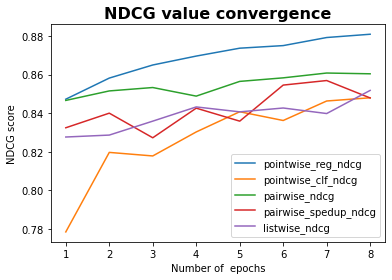

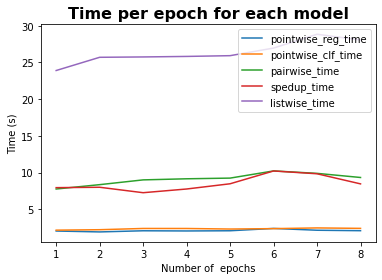

In [88]:
def autolabel(ax, rects, labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for l, rect in zip(labels, rects):
        height = rect.get_height()
        ax.annotate('{}'.format(l),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                   fontsize=7)

def compare_methods(labels, metrics, metrics_to_plot={"ndcg", "precision@05", "recall@05"}):
    """
    Constructs bar plots to compare different methods. 
    
    labels: list/tuple of length N
    metrics: list/tuple of length N, containing dictionary containing the test set results 
    metrics_to_plot: set of metrics to plot - each metric creates a separate plot 
    """
    assert len(metrics) == len(labels)
    
    x = np.arange(len(metrics_to_plot)) 
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics_to_plot), sharey=False)
    fig.set_figheight(7)
    fig.set_figwidth(15)
    
    colors = cm.get_cmap("Set1").colors

    for metric, ax, c in zip(metrics_to_plot, axes, colors):
        m = [_[metric][0] for _ in metrics]  
        std = [_[metric][1] for _ in metrics]
        x = np.arange(len(labels))
        rects = ax.bar(x, m, label=metric, color=c)
        
        l = ["{0:.4f}({1:.4f})".format(_[metric][0], _[metric][1]) for _ in metrics]
        autolabel(ax, rects, l)
        
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticks(np.linspace(0, 1, num=11))
        ax.set_ylim(ymin=min(m) - 0.05, ymax= max(m) + 0.05)
        ax.set_title(metric)
    
    

def plot_distribution(labels, q_metrics, metric="ndcg"):
    """
    Plots the distribution of NDCG scores
    
    labels: list/tuple of length N
    q_metrics: list/tuple of dictionaries with length N, containing the query level results
    metric: the metric to plot
    
    """
    
    n = len(labels)
    # nC2
    n_plots = int((n*(n-1))/2)
    
    fig, axes = plt.subplots(nrows=n_plots, ncols=1)
    fig.set_figheight(8 * n_plots)
    fig.set_figwidth(10)
    
    colors = cm.get_cmap("Set1").colors
    
    for idx, (i, j) in enumerate(itertools.combinations(range(n), 2)):
        ax = axes[idx]
        
        im = q_metrics[i][metric]
        jm = q_metrics[j][metric]
        
        ax.hist(im, bins=50, label=labels[i], color=colors[i], alpha=0.55)
        ax.hist(jm, bins=50, label=labels[j], color=colors[j], alpha=0.55)
        
        ax.set_title(f"{labels[i]} vs {labels[j]}")
        ax.legend()
        ax.set_ylabel("Count")
        ax.set_xlabel("NDCG (binned)")
        
#OWN PART FOR SECTION 6
#pairwise spedup data
pairwise_spedup_params_test = Namespace(epochs=8, lr=1e-3, batch_size=1, metrics={"ndcg@10","ndcg"})
pairwise_net_spedup = NeuralModule(1)
spedup = train_pairwise_spedup(pairwise_net_spedup, pairwise_spedup_params_test)
print(spedup)
list_pairwise_spedup_ndcg = []
for i in spedup['metrics_val']:
    list_pairwise_spedup_ndcg.append(i['ndcg'][0])
    perf_dict['pairwise_spedup_ndcg'] = list_pairwise_spedup_ndcg

#listwise data 
listwise_params_test = Namespace(epochs=8, lr=1e-3, batch_size=1, metrics={"ndcg"})
listwise_net = NeuralModule(1)
listwise = train_listwise(listwise_net, listwise_params_test)
print(listwise)
list_listwise_ndcg = []
for i in listwise['metrics_val']:
    list_listwise_ndcg.append(i['ndcg'][0])
    perf_dict['listwise_ndcg'] = list_listwise_ndcg

%matplotlib inline
plt.plot(perf_dict['pointwise_reg_ndcg'], label='pointwise_reg_ndcg')
plt.plot(perf_dict['pointwise_clf_ndcg'], label='pointwise_clf_ndcg')
plt.plot(perf_dict['pairwise_ndcg'],label='pairwise_ndcg')
plt.plot(perf_dict['pairwise_spedup_ndcg'],label='pairwise_spedup_ndcg')
plt.plot(perf_dict['listwise_ndcg'],label='listwise_ndcg')
plt.legend(loc='lower right')
plt.title("NDCG value convergence", fontsize=16, fontweight='bold')
plt.xlabel("Number of  epochs")
plt.xticks(np.arange(0,8),np.arange(1,9))
plt.ylabel("NDCG score")
plt.show()

%matplotlib inline
plt.plot(perf_dict['pointwise_reg_time'][:8], label='pointwise_reg_time')
plt.plot(perf_dict['pointwise_clf_time'][:8], label='pointwise_clf_time')
plt.plot(perf_dict['pairwise_time'], label='pairwise_time')
plt.plot(perf_dict['spedup_time'],label='spedup_time')
plt.plot(perf_dict['listwise_time'],label='listwise_time')
plt.legend(loc='upper right')
plt.title("Time per epoch for each model", fontsize=16, fontweight='bold')
plt.xlabel("Number of  epochs")
plt.xticks(np.arange(0,8),np.arange(1,9))
plt.ylabel("Time (s)")
plt.show()

In [48]:
# Load metrics and models

pointwise_regr_model = NeuralModule(1)
pointwise_regr_model.load_state_dict(torch.load("./pointwise_regr_wt"))

pointwise_clf_model = NeuralModule(5)
pointwise_clf_model.load_state_dict(torch.load("./pointwise_clf_wt"))
pointwise_clf_pred_fn = partial(clf_pred, net=pointwise_clf_model)

pairwise_model = NeuralModule(1)
pairwise_model.load_state_dict(torch.load("./pairwise_wt"))

listwise_model = NeuralModule(1)
listwise_model.load_state_dict(torch.load("./listwise_wt"))


methods = [
    {"results_file": "./pointwise_regression.json", "label": "Pointwise (R)"},
    {"results_file": "./pointwise_classification.json", "label": "Pointwise (C)"},
    {"results_file": "./pairwise.json", "label": "Pairwise"},
    {"results_file": "./listwise.json", "label": "Listwise"}
]

labels = []
results = []
q_results = []
for m in methods:
    labels.append(m["label"])
    
    with open(m["results_file"]) as reader:
        r = json.load(reader)
    
    results.append(r["test_metrics"])
    q_results.append(r["test_query_level_metrics"])



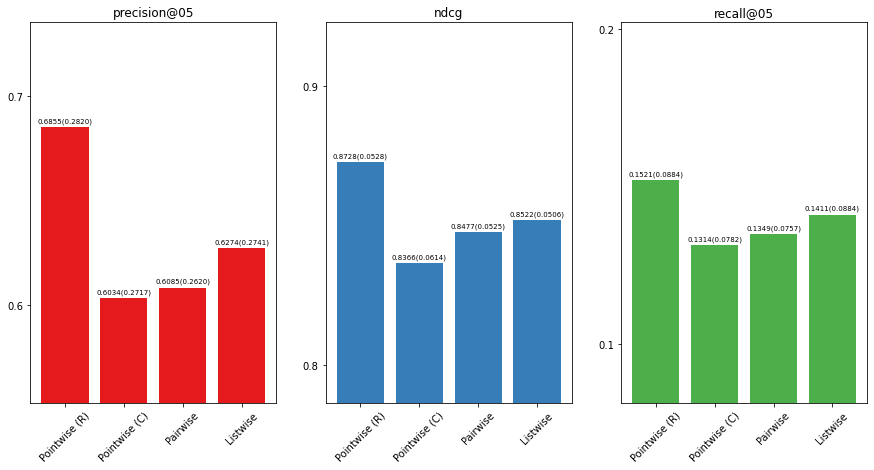

In [49]:
compare_methods(labels, results)

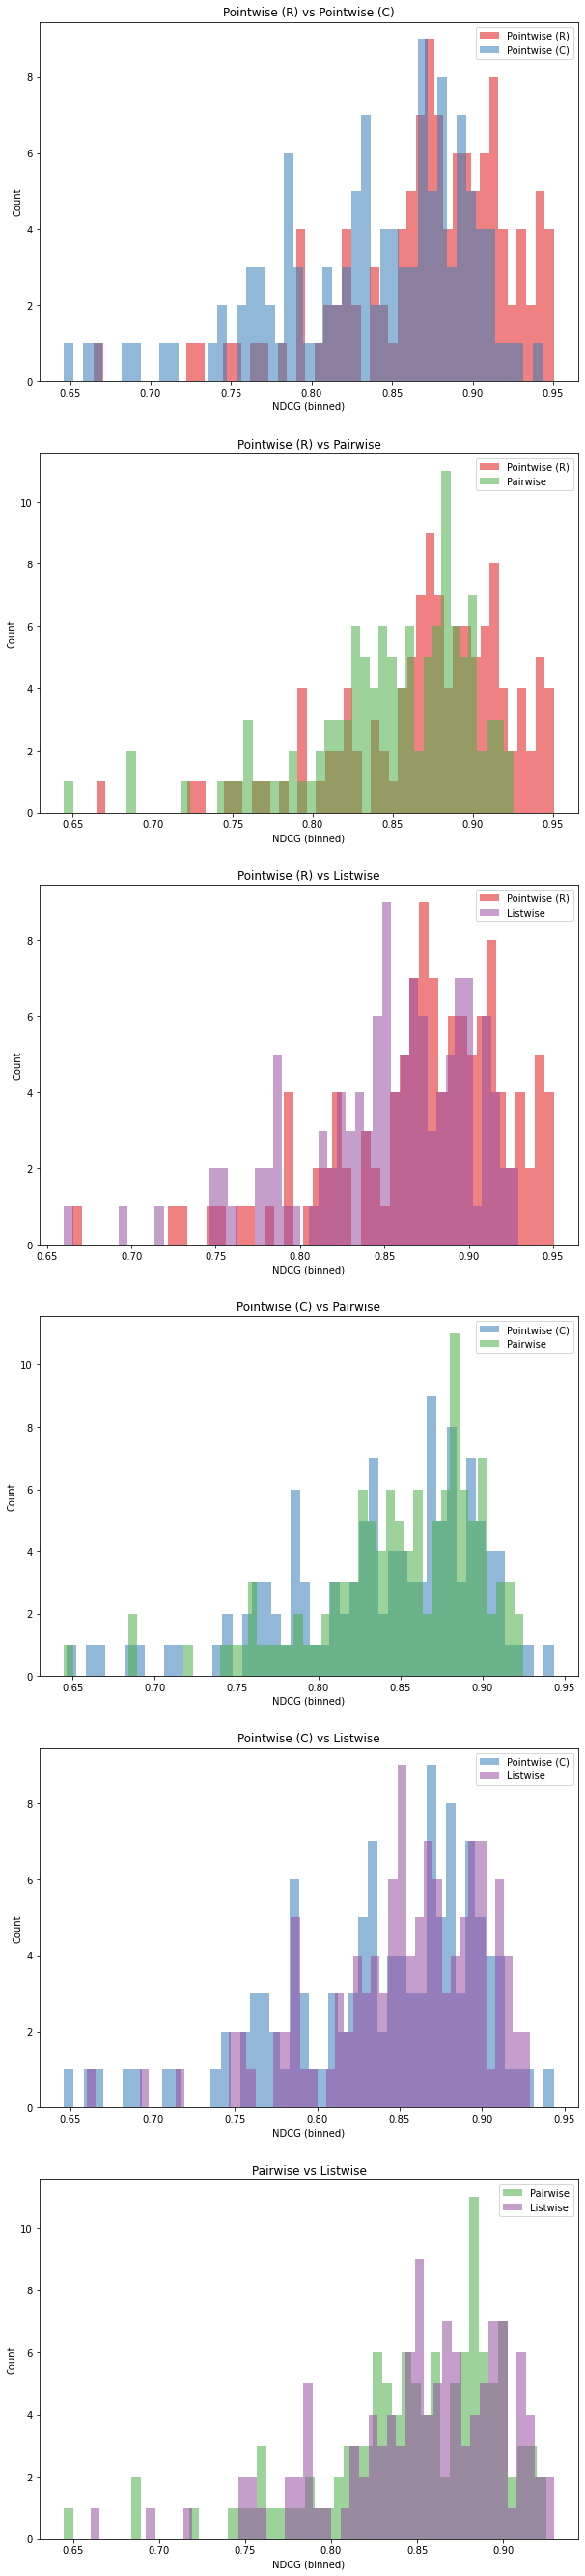

In [50]:
plot_distribution(labels, q_results)

In the next cell, report the performance metrics for the methods (25 points):



|     Model    | NDCG (s.d)| Precision@5 (s.d) | Recall@5 (s.d) |
|:------------:|:----------:|:-----------:|:--------:|
| Pointwise(R) |            |             |          |
| Pointwise(C) |            |             |          |
|   Pairwise   |            |             |          |
|   Listwise   |            |             |          |



**Rubric:** Each reported <Method, Metric> carries 2 points. 


|     Model    | NDCG (s.d)| Precision@5 (s.d) | Recall@5 (s.d) |
|:------------:|:----------:|:-----------:|:--------:|
| Pointwise(R) |0.8728(0.0528)| 0.6855(0.2820)            | 0.1521(0.0884)         |
| Pointwise(C) |  0.8366(0.0614)    | 0.6034(0.2717)            |   0.1314(0.0782)       |
|   Pairwise   |  0.8477(0.0525)    | 0.6085(0.2620)            |    0.1349(0.0757)      |
|   Listwise   |  0.8522(0.0506)    | 0.6274(0.2741)            |    0.1411(0.0884)      |



Surprisingly, it appears that our pointwise regression implementation outperforms all other models in each metric, but this difference might not be significant. This is in stark contrast to the claim that scores should not be considered independently and that hence ranking is not a classification or regression problem. The difference between pointwise regression and pointwise classification could be explained by the fact that for classification, you pick the highest score from the vector of labels, of which the index then represents your class label, while for regression you output a continuous scalar value. This may give a more correct ranking than classification, even though these approaches are not ideal. This however does not explain the difference in NDCG, precision and recall, because these should be higher when actually comparing documents with each other through the pairwise and listwise models. One possible explanation might be that this specific dataset happens to work better with pointwise models. 
We are unsure why our pairwise implementation sometimes outperforms the listwise approach, sometimes not. One reason could be that differences between the pairwise and the listwise approaches might not be statistically significant (when looking at the standard deviations, you can see that they overlap). Another reason is that there might be some errors in our implementations of these models. In this case listwise is performing better which can be expected based on the theory of these models.


Consider now the binned histograms denoting a selection of the queries on which the NDCG is tested. In the pointwise regression vs classification plot, classification seems to, in line with the bar plots, have the upper hand when looking at the NDCG range from 0.80-0.95. Comparing the pointwise regression to the pairwise, the pointwise still dominates the higher NDCG range, but compared to the pointwise classification, the pairwise distribution is more shifted to the right, meaning that it has more values in the higher NDCG range. In the case of the listwise values and in line with the bar plots, pointwise regression still dominates the higher NDCG values. The listwise distribution seems to have a few more queries having a NDCG value in the range of 0.90-0.93, but the pairwise distribution has more queries that have a score between 0.80-0.90, compensating for the higher NDCG values for the listwise distribution. The histogram of the pointwise classification has more queries around the 0.80 bin, which explains the lower average NDCG in the bar plots.



#Conclusion about the NDCG covergence and Time comparison

Regarding the time per epoch, we can see that the listwise model takes the most time by far. This is in line with our expectations, since listwise has to create all the tensors for each combination of documents swaps, which is computationally expensive. Since this is not done during query time, it can be okay to implement this technique with adequate computing power to train the model offline. It is also interesting to see that the time increases with epochs and we are unsure why that happens. It can be affected by a number of factors from cpu heat to background processes to the implementation style. Pairwise models show a similar behavior. They also take more time than simpler methods like pointwise, because it needs to check document pairs. The sped-up version is performing slightly better in terms of time than the vanilla implementation which is in line with the expectations. With larger datasets this difference can be significant so using this implementation is justified. It is noteworthy that previous runs showed bigger differences. Pointwise naturally takes the least time because it doesn’t have to make comparisons between anything, it’s just trying to predict the score/label. 


Write a conclusion in the next cell, considering (45 points):
- rates of convergence
- time complexity
- performance wrt the 3 metrics
- performance across queries
- ... any other observations

# Chapter 2: Online LTR (180 points) <a class="anchor" id="onLTR"></a>

[Back to TOC](#top)

In this part we want to use user interactions for training learning to rank algorithms.
This part consists of the following sections:
 - Clicks Simulation (15 points)
 - Counterfactual Learning to Rank (80 points)
 - Online Evaluation (50 points)


## Section 1: Clicks Simulation (15 points) <a class="anchor" id="clicks"></a>

[Back to TOC](#top)

In online LTR, we work with user interactions such as clicks.
One way to test online LTR algorithms is to conduce semi-synthetic experiments.
In semi-synthetic experiments, the feature vectors of a LTR dataset (similar to what you used in Part 1) are used.
But instead of using the relevance labels for training the LTR algorithm, **simulated clicks** are used.

In this section we want to simulate clicks based on the labels and use the generated clicks in later sections to train our Counterfactual LTR (CLTR) algorithm.

First we need to have a *production ranker* that determines the order of documents for each query.
The click probability of each document depends on its rank in the results list as well as its relevance.

In [51]:
ranks = dataset.load_production_ranker()
print(f'ranks has {len(ranks.keys())} keys: {ranks.keys()}')
for key in ranks:
    print(f'{key} shape:{ranks[key].shape}')
    
data.train.ranks = ranks['train']
data.validation.ranks = ranks['valid']
data.test.ranks = ranks['test']

ranks has 3 keys: dict_keys(['train', 'valid', 'test'])
train shape:(85227,)
valid shape:(12794,)
test shape:(29881,)


**Implementation (5 points):**
Now use the `ranks` to generate clicks.
We assume documents with label $[3,4]$ are relevant and labels $[0,1,2]$ are non-relevant.
We also assume the examination probability of a document at rank $r$ is $\frac{1}{r}$.
Finally, we assume a $0.05$ noise.

This means that the click probability of a document with label $[3,4]$ at rank $r$ is $\frac{1}{r}$, while the click probability of a document with label $[0,1,2]$ at rank $r$ is $\frac{0.05}{r}$.

In [52]:
# TODO: Implement this! (5 points)
def generate_clicks(ranking, query_labels):
    """
    Generates random clicks based on the given list of ranking and relevance labels for the documents of one query.
    Input:
        ranking: contains the rank of documents, eg. ranking[5]=0 means that document 5 is shown at rank 0.
        query_labels: contains the labels of documents, eg. query_labels[5]=3 means that document 5 has a label equal to 3.
    Output:
        A np.array of clicked positions, eq. clicked=[1,4] meanse that documents at ranks 1 and 4 have been clicked. Note that document at rank 1 may differ from document 1 (see description of ranking input).
        
    Hint: Use the np.random.binomial function for generating click from probability.
    """
    theta = 1. / np.arange(1, ranking.shape[0] + 1)
    noise_prob = 0.05 * theta
    # YOUR CODE HERE
    x = np.argsort(ranking)
    sort_rank = np.sort(ranking,0)
    sorted_labels = query_labels[x]
    list_prob = np.where(sorted_labels > 2, theta, noise_prob)
    clicked_val = np.random.binomial(1,list_prob,len(sorted_labels))
    clicked = sort_rank[1 == clicked_val]
    return clicked.astype(np.int32)
 

In [53]:
ranking = np.array([2, 1, 3, 0, 4, 7, 5, 6])
labels = np.array([0, 3, 4, 1, 1, 2, 4, 3])

np.random.seed(4)
print(f'clicks: {generate_clicks(ranking, labels)}')
print('expected clicks for seed 4: [0 1 6]')



clicks: [0 1 6]
expected clicks for seed 4: [0 1 6]


**Implementation (10 points):**
Use `generate_clicks` to simulate clicks for different query sessions.
For this, randomly select a query id, generate random clicks on documents of that query using your `generate_clicks` implementation and only keep the clicks on `topk` positions (i.e. do not consider clicks on ranks after `topk` rank).
Repeat this process until you have `click_count` number of clicks.

In [54]:
# TODO: Implement this! (10 points)
def simulate_clicks(data, split_name, click_count, topk=20):
    """
    Simulate click_count clicks on topk results on the specified split of the data.
    Output:
        A list L=[L_0, L_1, ..., L_n] of lists. Each L_i is itself a list of clicks over the documents of query number i, eg. L_0=[0,2,0,1,0,5,2] means that in the sessions of the first query, the documents at positions 0,1,2 and 5 were clicked 3,1,2 and 1 times, respectively.
    """
    data_split = getattr(data, split_name)
    num_queries = data_split.doclist_ranges.shape[0] - 1
    clicks = [[] for _ in range(num_queries)]
    np.random.seed(42)
    
    # YOUR CODE HERE
    num_clicks = 0
    
    while click_count > num_clicks:
        rnd_qid = np.random.randint(0, num_queries)
        i,j = data_split.query_range(rnd_qid)
        ranks = data_split.ranks[i:j]
        labels = data_split.query_labels(rnd_qid)
        gen_clicks = generate_clicks(ranks, labels)
        gen_clicks = gen_clicks[gen_clicks < topk]
        if len(gen_clicks) == 0:
            continue
        clicks[rnd_qid].extend(gen_clicks)
        num_clicks += len(gen_clicks)
        
    return clicks

Use `simulate_clicks` function to simulate clicks for train and validation sets.

**Note:**
You can dump your generated clicks using pickle or numby and load them in your future runs to avoid long waiting times.

In [55]:
train_clicks = simulate_clicks(data,'train', click_count = 10000)

assert isinstance(train_clicks, list)
session_clicks = np.array(list(map(len, train_clicks)))
print(f'{session_clicks.sum()} clicks simulated over {session_clicks.shape[0]} queries.')
print(f'On average, each session has {session_clicks.mean()} clicks.')
print(f'min number of clicks per session:{session_clicks.min()}')
print(f'max number of clicks per session:{session_clicks.max()}')



10000 clicks simulated over 2735 queries.
On average, each session has 3.656307129798903 clicks.
min number of clicks per session:0
max number of clicks per session:43


For our new click data, we need a new dataloader.
`QueryGroupedOnlineLTRData` provides what you will need for training an LTR model from the clicks:

In [56]:
class QueryGroupedOnlineLTRData(Dataset):
    def __init__(self, data, split, clicks, topk):
        self.split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert self.split is not None, "Invalid split!"
        self.clicks = clicks
        self.topk = topk
    
    def __len__(self):
        return self.split.num_queries()

    def __getitem__(self, q_i):
        s_i = self.split.doclist_ranges[q_i]
        e_i = self.split.doclist_ranges[q_i + 1]
        feature_ = self.split.feature_matrix[s_i:e_i,:]
        ranking = self.split.ranks[s_i:e_i]
        inverse_ranking = np.argsort(ranking)
#       We re-order the rows of feature matrix so that in coincides with the ranking of documents.
#       We also cut the documents after rank topk.
        feature = torch.FloatTensor(feature_[inverse_ranking[:self.topk],:])
        clicks = self.clicks[q_i]
        return q_i, feature, clicks
    
def qgo_collate_fn(batch):
    
    qids = []
    features = []
    clicks = []
    
    for (q, f, l) in batch:
        qids.append(q)
        features.append(f)
        clicks.append(l)
    return qids, features, clicks
    

## Section 2: Counterfactual LTR (90 points) <a class="anchor" id="cLTR"></a>

[Back to TOC](#top)

Now we want to use the simulated clicks and train a counterfactual LTR algorithm.
We will use a simple loss function:

$$
L=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} r(d, q) \cdot \lambda(\bar{rank}(d, D_q))
$$
where $Q$ is the set of queries, $D_q$ is the list of documents shown to the user for query $q$, $r(d, q)$ is the relevance of document $d$ to query $q$ and $rank(d, D_q)$ is the rank of $d$ in $D_q$.

In this assignment, we use sigmoid-like bound for $\lambda(\bar{rank}(d, D_q))$:

$$
\lambda(\bar{rank}(d, D_q)) = \sum_{d' \in D_q} log\left(
1+exp\left(-2\cdot(f(d)-f(d')\right)
\right)
$$


### Section 2.1. Biased LTR (20 points)

Remember that we do not have the explicit relevance in the online settings.
Instead, we have to learn from the clicks.
Clicks, implicitly indicate relevance.
A naive approach for learning from clicks would be to replace relevance with clicks and train a model with the loss function:

$$
L_{biased}=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} c(d, q) \cdot \lambda(\bar{rank}(d, D_q))
$$
where $c(d, q)$ indicates the number of times $d$ was clicked for query $q$.

In [57]:
def online_loss_biased(scores, clicks):
    """
    Compute and return the biased online loss for a single query. To compute this, use L_{biased} formula above.
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    clicks: list of clicked ranks. 
    
    Note: the scores are aligned with the click positions, i.e. scores[0] corresponds to the 0 rand, etc.
    
    """
    from collections import Counter
    click_counts = Counter(clicks)
    
    # YOUR CODE HERE
    fdfdi = scores - torch.squeeze(scores, 1)
    lambda_inner = torch.log(1 + torch.exp(-2 * fdfdi))
    lambda_ = torch.sum(lambda_inner, dim=1)
    ccnts = np.bincount(clicks, minlength=scores.shape[0])
    ccnts = torch.FloatTensor(ccnts)
    loss = torch.sum(ccnts * lambda_)
    return loss

In [58]:
scores = torch.FloatTensor([1.2, -2, 1.1, 2.4, 0, 1.2])[:,None]
clicks = [0, 0, 1, 3, 1, 4, 0, 5, 0, 1, 2]
print(f'biased loss: {online_loss_biased(scores, clicks)}')
print(f'expected: -6.205410003662109')



biased loss: 139.16244506835938
expected: -6.205410003662109


### Section 2.2. Unbiased LTR (10 points)
Now modify `online_loss_biased` to debias the clicks, using IPS method:

$$
L_{unbiased}=\frac{1}{|Q|} \sum_{q \in Q} \sum_{d \in D_q} \frac{c(d, q)}{P\left(o(d,q)=1\right)} \cdot \lambda(\bar{rank}(d, D_q))
$$
where $P\left(o(d,q)=1\right)$ indicates the probability that $d$ was observed by the user for query $q$.

In [59]:
# TODO: Implement this! (10 points)
def online_loss_unbiased(scores, clicks):
    """
    Compute and return the unbiased online loss *for a single query*. To compute this, use L_{unbiased} formula above.
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    clicks: list of clicked ranks. 
    
    Note 1: the scores are aligned with the click positions, i.e. scores[0] corresponds to the 0 rand, etc.
    Note 2: the weights are provided.
    
    """
    from collections import Counter
    click_counts = Counter(clicks)
    weights = torch.Tensor((1./np.arange(1,scores.shape[0]+1))[:,None])

    # YOUR CODE HERE
    ccnts = np.bincount(clicks, minlength=scores.shape[0])
    fdfdi = scores - torch.squeeze(scores, 1)
    lambda_inner = torch.log(1 + torch.exp(-2 * fdfdi))
    lambda_ = torch.sum(lambda_inner, dim=1)
    ccnts = torch.FloatTensor(ccnts)
    loss = torch.sum(ccnts/torch.squeeze(weights, 1) * lambda_)

    return loss

In [60]:
scores = torch.FloatTensor([1.2, -2, 1.1, 2.4, 0, 1.2])[:,None]
clicks = [0, 0, 1, 3, 1, 4, 0, 5, 0, 1, 2]
print(f'biased loss: {online_loss_unbiased(scores, clicks)}')
print(f'expected: -17.11062240600586')


biased loss: 323.6814270019531
expected: -17.11062240600586


**Implementation (60 points):**
In the next cell, write a wrapper that uses your loss functions and simulated clicks to train an online LTR method (no evaluation on validation set is required):

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 10 points
 - Loss calculation: 10 points
 - Training (e.g optimizer, zero_grad, backward): 10 points
 - Performance as expected for biased loss: 15 points
 - Performance as expected for unbiased loss: 15 points

In [61]:
# TODO: Implement this! (60 points)
def train_online(net, train_clicks, loss_fn, params):
    """
    Use QueryGroupedOnlineLTRData to load the data train split and clicks.
    Use the appropriate loss_fn (biased/unbiased).
    No need to use validation set.
    """
    # YOUR CODE HERE
    optimizer = Adam(net.parameters(), params.lr)
    train_dl = DataLoader(QueryGroupedOnlineLTRData(data, "train", train_clicks,params.topk), batch_size=1, shuffle=True, collate_fn=qgo_collate_fn)
    for epoch in range(params.epochs):
        net.train()
        #print(f"epoch {epoch + 1}")
        for (qids, x, y) in train_dl:
            for q_i, features_i, clicks_i in zip(qids, x, y):
                optimizer.zero_grad()
                output = net(features_i)
                # Compute loss between output and y
                loss = loss_fn(output, clicks_i)
                #the case when the loss is None - in this case we do not compute the gradients
                if loss is None:
                    continue
                # Compute gradients

                loss.backward()

                # Update weights
                optimizer.step()

In [62]:
params = Namespace(epochs=3, lr=1e-3, topk=20)
train_clicks = simulate_clicks(data,'train', click_count = 50000)
biased_net = NeuralModule(1)
train_online(biased_net, train_clicks, online_loss_biased, params)
unbiased_net = NeuralModule(1)
train_online(unbiased_net, train_clicks, online_loss_unbiased, params)

In [63]:
evaluate_model(biased_net, 'test', print_results=True)
evaluate_model(unbiased_net, 'test', print_results=True)


"metric": "mean" ("standard deviation")
dcg: 107.6622 (24.45322)
dcg@03: 18.0344 (8.48421)
dcg@05: 22.6243 (10.12942)
dcg@10: 29.9799 (11.48599)
dcg@20: 39.9682 (13.55011)
ndcg: 0.8299 (0.05982)
ndcg@03: 0.6172 (0.26286)
ndcg@05: 0.5855 (0.22300)
ndcg@10: 0.5711 (0.17324)
ndcg@20: 0.5804 (0.14434)
precision@01: 0.7265 (0.44576)
precision@03: 0.6439 (0.31944)
precision@05: 0.5573 (0.27027)
precision@10: 0.4573 (0.21216)
precision@20: 0.3739 (0.17512)
recall@01: 0.0329 (0.02937)
recall@03: 0.0885 (0.06364)
recall@05: 0.1248 (0.08864)
recall@10: 0.1965 (0.10962)
recall@20: 0.3115 (0.13921)
relevant rank: 70.7868 (66.45438)
relevant rank per query: 1821.7009 (1075.19713)


"metric": "mean" ("standard deviation")
dcg: 109.9815 (24.58191)
dcg@03: 19.4069 (8.54619)
dcg@05: 24.6873 (9.80353)
dcg@10: 32.9454 (12.08532)
dcg@20: 42.9117 (13.77508)
ndcg: 0.8481 (0.05649)
ndcg@03: 0.6596 (0.25013)
ndcg@05: 0.6378 (0.20508)
ndcg@10: 0.6249 (0.16943)
ndcg@20: 0.6228 (0.13746)
precision@01: 0.7350 (0.44131)
precision@03: 0.6724 (0.31118)
precision@05: 0.6120 (0.26187)
precision@10: 0.5197 (0.22579)
precision@20: 0.4047 (0.17184)
recall@01: 0.0339 (0.02901)
recall@03: 0.0903 (0.05605)
recall@05: 0.1362 (0.07942)
recall@10: 0.2220 (0.10574)
recall@20: 0.3378 (0.13407)
relevant rank: 65.1468 (62.09701)
relevant rank per query: 1676.5556 (1026.42507)


{'dcg': (109.98145320570762, 24.58191149314092),
 'dcg@03': (19.406890774817125, 8.546192390989615),
 'dcg@05': (24.6872700873675, 9.80353040072785),
 'dcg@10': (32.94538089573715, 12.085323145696021),
 'dcg@20': (42.91165703116547, 13.775082687619479),
 'ndcg': (0.8481465812807779, 0.0564906730243345),
 'ndcg@03': (0.6595943536700674, 0.2501274447165053),
 'ndcg@05': (0.6377865410375048, 0.20507504788266312),
 'ndcg@10': (0.6249366219643575, 0.1694285965902283),
 'ndcg@20': (0.6228410429213334, 0.13745922487241813),
 'precision@01': (0.7350427350427351, 0.44131044934788327),
 'precision@03': (0.6723646723646725, 0.3111810238384763),
 'precision@05': (0.6119658119658119, 0.2618678446505939),
 'precision@10': (0.5196581196581196, 0.2257899016763779),
 'precision@20': (0.4047008547008547, 0.1718405773278346),
 'recall@01': (0.03390949716347433, 0.02901270391638303),
 'recall@03': (0.0902827134475243, 0.056046951588237456),
 'recall@05': (0.136230191320552, 0.07942264227009906),
 'recall@

In [64]:
seed(42)
train_clicks = simulate_clicks(data,'train', click_count = 50000)
params = Namespace(epochs=3, 
                    lr=1e-3,
                    batch_size=1,
                    topk=20,
                    metrics={"ndcg", "precision@05", "recall@05"})
biased_model = NeuralModule(1)

create_results(biased_model, 
               train_online, 
               biased_model,
               "./biased_model.json",
               train_clicks,
               online_loss_biased,
               params)
# persist model
torch.save(biased_model.state_dict(), "./biased_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 109.4927 (24.42236)
dcg@03: 19.1368 (8.88010)
dcg@05: 24.3631 (10.14720)
dcg@10: 32.2042 (12.22154)
dcg@20: 41.7522 (13.51039)
ndcg: 0.8447 (0.05600)
ndcg@03: 0.6557 (0.27141)
ndcg@05: 0.6316 (0.21622)
ndcg@10: 0.6121 (0.17298)
ndcg@20: 0.6077 (0.14063)
precision@01: 0.7179 (0.45000)
precision@03: 0.6553 (0.32005)
precision@05: 0.5983 (0.28102)
precision@10: 0.4863 (0.23128)
precision@20: 0.3838 (0.17697)
recall@01: 0.0331 (0.03079)
recall@03: 0.0877 (0.05904)
recall@05: 0.1303 (0.07483)
recall@10: 0.2052 (0.10380)
recall@20: 0.3195 (0.13986)
relevant rank: 66.5756 (62.75663)
relevant rank per query: 1713.3248 (1021.57314)


In [65]:
seed(42)

params = Namespace(epochs=3, 
                    lr=1e-3,
                    batch_size=1,
                    topk=20,
                    metrics={"ndcg", "precision@05", "recall@05"})
unbiased_model = NeuralModule(1)

create_results(unbiased_model, 
               train_online, 
               unbiased_model,
               "./unbiased_model.json",
               train_clicks,
               online_loss_unbiased,
               params)
# persist model
torch.save(biased_model.state_dict(), "./unbiased_wt")

Training Model


"metric": "mean" ("standard deviation")
dcg: 110.3949 (24.45440)
dcg@03: 20.0676 (8.25462)
dcg@05: 25.2162 (9.57285)
dcg@10: 33.4602 (12.00318)
dcg@20: 43.3478 (14.01973)
ndcg: 0.8517 (0.05296)
ndcg@03: 0.6817 (0.23561)
ndcg@05: 0.6512 (0.19143)
ndcg@10: 0.6350 (0.16096)
ndcg@20: 0.6296 (0.14093)
precision@01: 0.7692 (0.42133)
precision@03: 0.7123 (0.31399)
precision@05: 0.6342 (0.26447)
precision@10: 0.5188 (0.23313)
precision@20: 0.4098 (0.18493)
recall@01: 0.0345 (0.02775)
recall@03: 0.0964 (0.05957)
recall@05: 0.1404 (0.07595)
recall@10: 0.2203 (0.10399)
recall@20: 0.3387 (0.14126)
relevant rank: 65.4168 (63.01014)
relevant rank per query: 1683.5043 (1027.66717)


In [66]:
# YOUR CODE HERE


### Section 2.3: Comparison (20 points)

Now we can compare two loss functions: biased and unbiased.
We want to see how they can improve by increasing the number of training clicks.
Train both biased and unbaised models on $[2000, 10000, 50000]$ number of clicks and compare the results.

Plot the results in a **single** figure with x-axis showing the number of trainin clicks and y-axis showing the nDCG@10.
Discuss your observations.


**Rubric:**
- Two curves are plotted in the figure: 10 points
- Clear titles, x label, y labels and legends (if applicable): 5 points
- Explain what you observe: 5 points

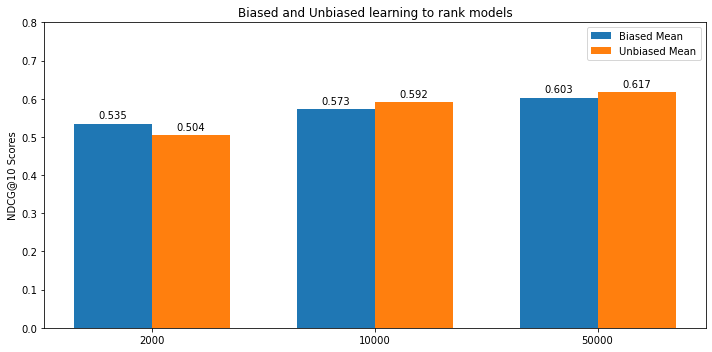

Conclusion: Contrary our expectations, biased model works better for smaller click numbers (5000,10000) the reason behind it can be randomness and the size of training data. Regarding the unbiased model, using more training data is improve performance while results for biased model are almost the same after each training. The similar experiment for unbiased model can be found in this paper [1]
[1] - Harrie Oosterhuis, Maarten de Rijke .(2020) Policy-Aware Unbiased Learning to Rank for Top-𝑘 Rankings


In [67]:
# YOUR CODE HERE
params = Namespace(epochs=8, lr=1e-3, topk=20)
biased_mean = []
unbiased_mean = []
for i in [2000,10000,50000]: 
    train_clicks = simulate_clicks(data,'train', click_count = i)
    biased_net = NeuralModule(1)
    train_online(biased_net, train_clicks, online_loss_biased, params)
    unbiased_net = NeuralModule(1)
    train_online(unbiased_net, train_clicks, online_loss_unbiased, params)
    biased = evaluate_model(biased_net, 'test', print_results=False)
    biased_ndcg10 = biased['ndcg@10']
    unbiased = evaluate_model(unbiased_net, 'test', print_results=False)
    unbiased_ndcg10 = unbiased['ndcg@10']
    biased_mean.append(np.round_(biased_ndcg10[0],3))
    unbiased_mean.append(np.round(unbiased_ndcg10[0],3))

labels = ['2000', '10000', '50000']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(x - width/2, biased_mean, width, label='Biased Mean')
rects2 = ax.bar(x + width/2, unbiased_mean, width, label='Unbiased Mean')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NDCG@10 Scores')
ax.set_title('Biased and Unbiased learning to rank models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim((0.0,0.8))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

print("Conclusion: Contrary our expectations, biased model works better for smaller click numbers (5000,10000) the reason behind it can be randomness and the size of training data. Regarding the unbiased model, using more training data is improve performance while results for biased model are almost the same after each training. The similar experiment for unbiased model can be found in this paper [1]")
print("[1] - Harrie Oosterhuis, Maarten de Rijke .(2020) Policy-Aware Unbiased Learning to Rank for Top-𝑘 Rankings")

## Section 3: Online Evaluation (75 points) <a class="anchor" id="on_eval"></a>

[Back to TOC](#top)

Sometimes, in online search engines, we want to compare two or more different ranking functions based on the user interactions.
This comparison is done via online evaluation.

In this section we implement one of the online evaluation methods: probabilistic multileaving.

We compare three rankers:
 - Production ranker: the ranks that are provided to you for doing the click simulation.
 - Biased method from previous section.
 - Unbiased method from previous section

Before proceeding, we need some auxiliary functions:

 - `invert_ranking` gets the ranking and gives the inverted rankings. This means that for an input with `rank[d]=r`, the output would be `i_rank[r]=d`.


 - `get_predictions` gives a dictionary of predictions, i.e. `predictions[qid]` is the list of scores produced by the given model.


In [68]:
def get_predictions(net, test_clicks, topk):
    test_dl = DataLoader(QueryGroupedOnlineLTRData(data, 'test', test_clicks, topk), 
                          batch_size=1, 
                          shuffle=False,
                          collate_fn=qg_collate_fn)
    predictions = {}
    for qids, x, _ in test_dl:
        predictions[qids[0]] = net(x[0]).detach().numpy()[:,0]
    return predictions


def invert_rankings(rankings):
    '''
    Invert indices in a matrix of rankings, ranking per row.
    '''
    inverted = np.zeros(rankings.shape)
    
    inverted[np.arange(rankings.shape[0])[:,None],rankings] = np.arange(rankings.shape[1])[None,:]
    return inverted


The next cell helps you build the ranking matrix for each query in the test set.
The first row is the production ranker, the second row is the biased ranker and the third row is the unbiased ranker.

In [69]:
# we only need the ranking of the production ranker for the test set. No clicks have to be simulated here.
test_clicks = simulate_clicks(data, 'test', click_count = 0)
biased_predictions = get_predictions(biased_net, test_clicks, 20)
unbiased_prediction = get_predictions(unbiased_net, test_clicks, 20)

def get_ranking_matrix(qid, topk):
    ranking_matrix = np.empty([3, min(data.test.query_size(qid), topk)], dtype=np.int32)
    ranking = data.test.ranks[data.test.doclist_ranges[qid]:data.test.doclist_ranges[qid+1]]
    ranking_matrix[0,:] = np.arange(ranking_matrix.shape[1])
    ranking_matrix[1,:] = np.argsort(-biased_predictions[qid])
    ranking_matrix[2,:] = np.argsort(-unbiased_prediction[qid])
    return ranking_matrix

In [70]:
print(get_ranking_matrix(0, 20))

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [13  3  6  2 16 18  5  9  8 12 14  1 19  4  0 10  7 11 15 17]
 [ 6 13  2 18  3 15  1  0 11  8  5 16 19 12 14 10 17  9  4  7]]


### Section 3.1 Multileaving (10 points)

Given the rankings of multiple rankers, we want to decide how to fill the results list and show it to the users.
Implement the following function.

In [71]:
# TODO: Implement this! (10 points)
def make_multileaving(inverted_rankings, topk):
    '''
    ARGS: (all np.array of docids)
    - inverted_rankings: matrix (rankers x documents) where [x,y] corresponds to the rank of doc y in ranker x
    RETURNS
    - ranking of indices corresponding to inverted_rankings
    '''
    n_rankers = inverted_rankings.shape[0]
    n = inverted_rankings.shape[1]
    k = min(n, topk)

    # YOUR CODE HERE
    tau = 3
    inverted_rankings = inverted_rankings + 1 # to make sure we don't divide by 0
    norm_list = inverted_rankings
    interleaved_rank = []

    for i in range(topk):
        ranker = np.random.randint(0,n_rankers)

        #compute probabilities
        sum_rank_of_doc = np.sum(np.nan_to_num(1/norm_list**tau, posinf=0),1)
        
        prob_docs = np.nan_to_num(1/(inverted_rankings**tau)/sum_rank_of_doc[ranker],posinf=0)
        np.nan_to_num(prob_docs)

        #sample document
        sample_doc_rank = np.random.choice(inverted_rankings[ranker],1,p=prob_docs[ranker])
        doc_id = list(inverted_rankings[ranker]).index(sample_doc_rank)
        interleaved_rank.append(doc_id)
        
        # set document[] 0 to flag it as chosen
        norm_list[:,doc_id] = 0

    
    return interleaved_rank


In [72]:
print(make_multileaving(invert_rankings(get_ranking_matrix(0, 20)), 20))

[6, 13, 0, 3, 2, 1, 5, 16, 9, 7, 18, 4, 15, 11, 12, 19, 8, 14, 10, 17]


<ipython-input-71-7fdca7218687>:23: RuntimeWarning: divide by zero encountered in true_divide
  sum_rank_of_doc = np.sum(np.nan_to_num(1/norm_list**tau, posinf=0),1)
<ipython-input-71-7fdca7218687>:25: RuntimeWarning: divide by zero encountered in true_divide
  prob_docs = np.nan_to_num(1/(inverted_rankings**tau)/sum_rank_of_doc[ranker],posinf=0)


In [73]:
# YOUR CODE HERE


### Section 3.2: Probability of rankers (15 points)

We have shown the multileaved list to the user and they clicked on some documents.
In this function we want to calculate the probability that the clicked documents belong to a specific ranker.

Note that the results of rankers are not unique and each document in the results list may belong to different rankers.
So we need to assign a *probability* to each click belonging to each ranker.

In [74]:
# TODO: Implement this! (15 points)
def probability_of_list(result_list, inverted_rankings, clicked_docs):
    '''
    ARGS: (all np.array of docids)
    - result_list: the multileaved list
    - inverted_rankings: matrix (rankers x documents) where [x,y] corresponds to the rank of doc y in ranker x
    - clicked_docs: boolean array of result_list length indicating clicks
    RETURNS
    -sigmas: matrix (rankers x clicked_docs) with probabilty ranker added clicked doc
    '''
    n_docs = inverted_rankings.shape[1]
    n_rankers = inverted_rankings.shape[0]

    click_doc_ind = result_list[clicked_docs]
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [75]:
ranking_matrix = get_ranking_matrix(0, 20)
result_list = make_multileaving(invert_rankings(ranking_matrix), 20)
clicks = [0,4,9,10]
probabilities = probability_of_list(result_list, invert_rankings(ranking_matrix), clicks)
print(f'ranking matrix:\n {ranking_matrix}')
print(f'results list (shown to user):\n {result_list}')
print(f'clicked documents: {clicks}')
print(f'probabilities:\n {probabilities}')

<ipython-input-71-7fdca7218687>:23: RuntimeWarning: divide by zero encountered in true_divide
  sum_rank_of_doc = np.sum(np.nan_to_num(1/norm_list**tau, posinf=0),1)
<ipython-input-71-7fdca7218687>:25: RuntimeWarning: divide by zero encountered in true_divide
  prob_docs = np.nan_to_num(1/(inverted_rankings**tau)/sum_rank_of_doc[ranker],posinf=0)


TypeError: list indices must be integers or slices, not list

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Section 3.3: Preference matrix (10 points)

Given the probabilities of each ranker being clicked, we want to calculate a preference matrix that for each pair of rankers tells us which one is preferred by the clicks.

In [ ]:
# TODO: Implement this! (10 points)
def preferences_of_list(probs):
    '''
    ARGS:
    -probs: clicked docs x rankers matrix with probabilities ranker added clicked doc  (use probability_of_list)
    -n_samples: number of samples to base preference matrix on
    RETURNS:
    - preference matrix: matrix (rankers x rankers) in this matrix [x,y] > 0 means x won over y and [x,y] < 0 means x lost from y
      the value is analogous to the (average) degree of preference
    '''
    n_samples = 10
    n_clicks = probs.shape[0]
    n_rankers = probs.shape[1]
    
    # YOUR CODE HERE
    raise NotImplementedError()

def infer_preferences(inverted_rankings, result_list, clicked_docs):
    n_rankers = inverted_rankings.shape[0]
    if np.any(clicked_docs):
        return preferences_of_list(probability_of_list(result_list,
                                        inverted_rankings,
                                        clicked_docs))
    else:
        return np.zeros((n_rankers, n_rankers))


In [ ]:
print(preferences_of_list(probabilities))

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Now we can simulate the multileaving to see how our target rankers are evaluated by it.

In [ ]:
def simulate_multileaving(n_impressions, topk):
    n_samples = 10
    impressions = 0
    pref_update = 0
    total_pref = np.zeros((3, 3))
    for step_i in range(n_impressions):
        qid = np.random.randint(0, data.test.doclist_ranges.shape[0] - 1)

        start_i = data.test.doclist_ranges[qid]
        end_i = data.test.doclist_ranges[qid + 1]
        n_query_docs = end_i - start_i
        query_labels = data.test.label_vector[start_i:end_i]

        inverted_rankings = invert_rankings(get_ranking_matrix(qid, topk))
        multileaving = make_multileaving(inverted_rankings, topk)

        cur_clicks = generate_clicks(multileaving, query_labels)

        if np.any(cur_clicks):
            pref = infer_preferences(inverted_rankings, multileaving, cur_clicks)
            total_pref += pref
            pref_update += 1
    return total_pref / pref_update


In [ ]:
simulate_multileaving(10000, 20)

### Section 3.4: Analysis (40 points)

Analyze the behavior of your multileaving implementation by testing it with two different `topk` values: $[5,20]$ and with different number of evaluation clicks: $[2000, 10000, 50000]$.

Put the preference of the unbiased method over the biased method (i.e. `pref[2,1]` in the matrix output of `simulate_multileaving` function) for these experiments in a table.

**Rubric:**
- Six experiments: 12 points
- Analysis of the observations: 28 points

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()